### 吃吃吃吃

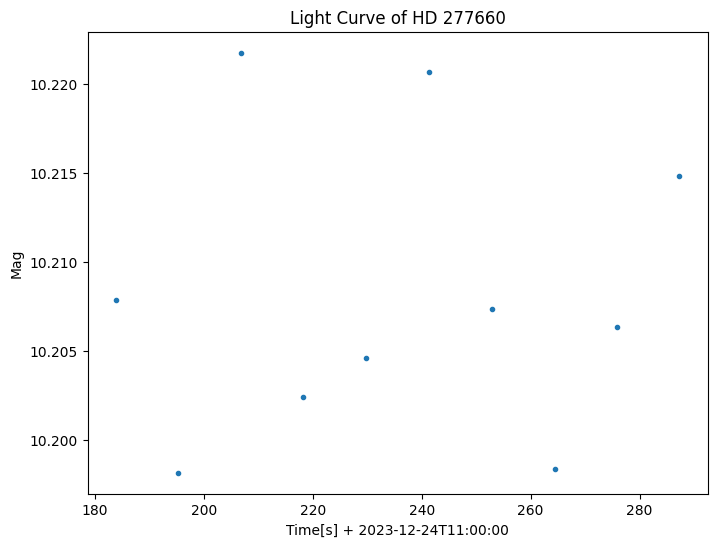

Period max =   5235.987755982989


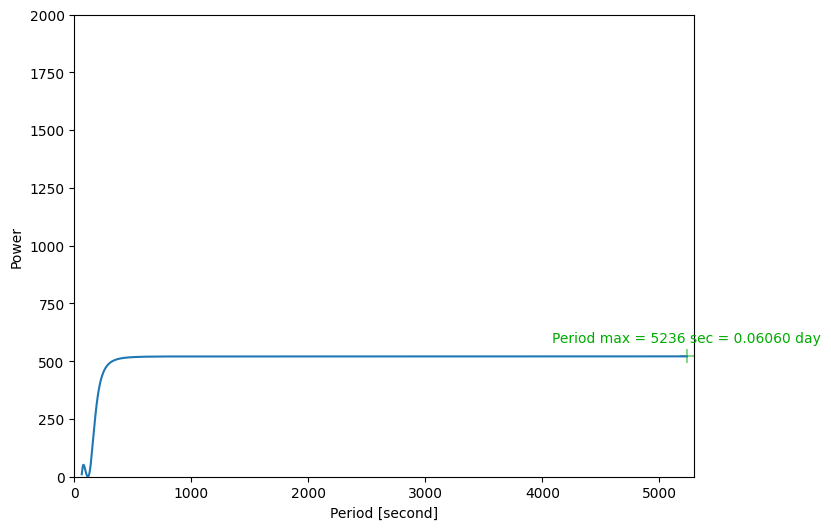

In [2]:
### 定标、测定星等程序
### 中山大学物理与天文学院  黄日 (GitHub: betelgeuse-nebula)
### 2024年1月7日

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
import os
import pandas as pd
# import fitparse

import shutil
# 源文件路径
file_path = 'example/Photometry_results.txt'

############################################################################
############################################################################


data = pd.read_table(file_path, header=1, delimiter='\t')

# n 是总测光的星的个数（定标星个数+1）

data = data.apply(lambda col: col[1:])

column_name = data.columns

n = len(column_name) - 2

Time = data['Relative Time'].astype(float)

m = len(Time)

# print(column_name)
# print("number of calib: ",n)
# print("number of time : ",m)
# print(data)

Prop_data = np.zeros((n))

Prop = 0
Prop_std = 0

weights = np.zeros((n))
normalized_weights = np.zeros((n))

Mag = [10.17, 9.75, 10.51, 10.03, 9.46, 10.58, 9.47]

MagVar = np.zeros((m))
MagVar_std = np.zeros((m))

for i in range(m):

    index = 0
    for star_name in column_name:
        if (star_name!="Relative Time")and(star_name!="..660"):
            logFlux = np.log10(data[star_name][i+1])
            Prop_data[index] = Mag[index] + 2.5*logFlux
            weights[index] = data[star_name][i+1]
            index += 1

    # 归一化权重
    normalized_weights = weights / np.sum(weights)

    # 计算 logFlux 到 Mag 的转换比 Prop （加权平均）
    Prop = np.sum(Prop_data * normalized_weights)

    # 计算 Prop 的（加权）标准差
    Prop_std = np.sqrt(np.sum(normalized_weights * (Prop_data - Prop)**2))

    # 计算目标星的星等
    logFlux = np.log10(data['..660'][i+1])
    MagVar[i] = Prop - 2.5*logFlux

    # 及其标准差
    MagVar_std[i] = logFlux * Prop_std


### 画光变曲线
# MagVar = np.sin(Time*0.002)
# plt.errorbar(Time, MagVar, yerr=MagVar_std, fmt='o', capsize=5)
plt.figure(figsize=(8,6))
plt.plot(Time, MagVar,'.')
plt.title('Light Curve of HD 277660')
plt.xlabel('Time[s] + 2023-12-24T11:00:00')
plt.ylabel('Mag')
# plt.ylim(9.4,9.6)
plt.savefig('light_curve.pdf')
plt.show()


#######################################################################
#######################################################################

import scipy.signal as signal

f = np.linspace(0.0012, 0.1, 10000) #要搜寻的频率域
pgram = signal.lombscargle(Time, MagVar, f, normalize=False)
Period = 2.0*np.pi/f
index_of_max = np.argmax(pgram)
period_max = Period[index_of_max] # in second
print("Period max =  ", period_max)

plt.figure(figsize=(8,6))

plt.scatter(Period[index_of_max], pgram[index_of_max], marker='+', s=100, c="#0a07")
plt.text(Period[index_of_max], pgram[index_of_max]+50, "Period max = %.0f sec = %.5f day"%(period_max,(period_max/86400)), fontsize=10, ha='center', va='bottom', color='#0a0f')

plt.plot(Period, pgram)
plt.xlabel("Period [second]")
plt.ylabel("Power")
plt.xlim(0,5300)
# plt.xlim(3000,3500)
plt.ylim(0,2000)
plt.savefig('period_power.pdf')
plt.show()
